In [17]:
import pandas as pd
import numpy as np
import torch
import joblib
import os
import json
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from transformers import AutoTokenizer, AutoModel

In [18]:
# Configuration
DATASET_PATH = "/home/fariz/Works/Malayalam-Emotion-Detector/github_test/Emotions data.xlsx"  # Update with your Excel file path
BERT_MODEL_PATH = "./bert_emotion_model"
SAVE_DIR = "./svm_bert_model"
os.makedirs(SAVE_DIR, exist_ok=True)

In [19]:
# Load dataset from Excel
df = pd.read_excel(DATASET_PATH)
texts = df['Text'].tolist()  # Replace 'text' with your text column name
labels = df['Emotion'].tolist()  # Replace 'emotion' with your label column name

In [20]:
# Load BERT components and label mapping
tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL_PATH)
model = AutoModel.from_pretrained(BERT_MODEL_PATH)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [21]:
# Load label mapping
with open(os.path.join(BERT_MODEL_PATH, "label_mapping.json")) as f:
    label_mapping = json.load(f)

In [22]:
# Convert labels to numerical values
label_to_id = {v: k for k, v in label_mapping.items()}
y = np.array([label_to_id[label] for label in labels])

In [23]:
def get_bert_embeddings(texts, batch_size=16):
    """Generate BERT embeddings using the fine-tuned model"""
    model.eval()
    embeddings = []
    
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        
        inputs = tokenizer(
            batch,
            padding=True,
            truncation=True,
            max_length=128,
            return_tensors="pt"
        ).to(device)
        
        with torch.no_grad():
            outputs = model(**inputs)
        
        # Use mean pooling of all token embeddings
        embeddings_batch = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
        embeddings.append(embeddings_batch)
    
    return np.vstack(embeddings)

# Generate BERT embeddings
print("Generating BERT embeddings...")
X = get_bert_embeddings(texts)

Generating BERT embeddings...


In [24]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [25]:
# Train SVM classifier
print("Training SVM classifier...")
svm = SVC(
    kernel='linear',
    probability=True,
    class_weight='balanced'
)
svm.fit(X_train, y_train)

Training SVM classifier...


SVC(class_weight='balanced', kernel='linear', probability=True)

In [26]:
# Evaluate
y_pred = svm.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_mapping.values()))


Classification Report:
              precision    recall  f1-score   support

     Abusive       0.17      0.19      0.18       189
       Anger       0.17      0.15      0.16       205
  Excitement       0.28      0.10      0.14       217
        Fear       0.25      0.18      0.21       211
       Happy       0.16      0.27      0.20       195
      Humour       0.14      0.37      0.20       192
        Love       0.26      0.17      0.21       174
         Sad       0.21      0.10      0.14       198
     Sarcasm       0.09      0.07      0.08       208
    Surprise       0.18      0.14      0.16       211

    accuracy                           0.17      2000
   macro avg       0.19      0.17      0.17      2000
weighted avg       0.19      0.17      0.17      2000



<Figure size 800x600 with 0 Axes>

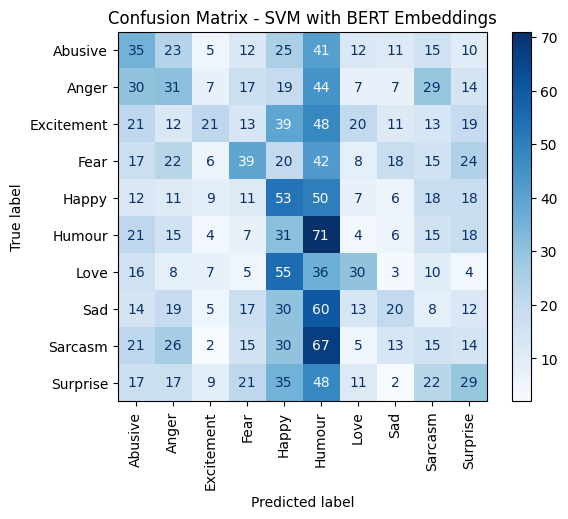

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=svm.classes_)

# Create ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[label_mapping[str(i)] for i in svm.classes_])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', xticks_rotation='vertical')
sns.set(style="whitegrid")

# Set title
disp.ax_.set_title("Confusion Matrix - SVM with BERT Embeddings")

plt.show()

In [30]:
# Save components
joblib.dump(svm, os.path.join(SAVE_DIR, "svm_model.pkl"))

# Save label mapping (same as BERT model's)
with open(os.path.join(SAVE_DIR, "label_mapping.json"), "w") as f:
    json.dump(label_mapping, f)

print(f"\nAll components saved to {SAVE_DIR}")


All components saved to ./svm_bert_model


In [31]:

# Example inference function
def predict_emotion(text):
    # Generate embedding
    embedding = get_bert_embeddings([text])
    
    # Predict
    pred_id = svm.predict(embedding)[0]
    proba = svm.predict_proba(embedding)[0]
    
    return {
        "emotion": label_mapping[str(pred_id)],
        "confidence": float(np.max(proba)),
        "probabilities": {label_mapping[str(i)]: float(p) for i, p in enumerate(proba)}
    }

# Test prediction
test_text = "സ്നേഹം ഒരുപാട് മാറ്റങ്ങൾ കൊണ്ടു വരും"
print("\nTest prediction:", predict_emotion(test_text))


Test prediction: {'emotion': 'Fear', 'confidence': 0.3631822310993136, 'probabilities': {'Abusive': 0.0608151890725638, 'Anger': 0.05450905215914406, 'Excitement': 0.06424994334005459, 'Fear': 0.3631822310993136, 'Happy': 0.1669050909176446, 'Humour': 0.09267729389054336, 'Love': 0.04780673009005987, 'Sad': 0.038566050453230895, 'Sarcasm': 0.03592039919728779, 'Surprise': 0.07536801978015813}}
